In [1]:
import os
import json
from copy import copy
import pandas as pd
from sklearn.isotonic import spearmanr
from scipy.stats import kendalltau
import numpy as np

PROTEINS = os.listdir("results")
PROTEINS = [file.split("-dist")[0] for file in PROTEINS if file.endswith("distances.json")]
EMBEDDINGS = ["grasr-cosine", "grasr-euclidean", "pca-cosine", "pca-euclidean", "zirke-euclidean", "zirke-cosine", "lmi-euclidean", "lmi-cosine", "lmi-30-euclidean", "lmi-30-cosine"]
EMBEDDINGS_LEGEND = ["GraSR cosine", "GraSR euclidean", "PCA cosine", "PCA euclidean", "Zernirke euclidean", "Zernike cosine", "LMI-10 euclidean", "LMI-10 cosine", "LMI-30 euclidean", "LMI-30 cosine"]

def compute_correlation(file1, file2, protein_filter=None, use_kendal=False) -> float:
    """
    Compute spearman and pearson correlation between two json files.

    Args:
        file1 (str): path to first json file
        file2 (str): path to second json file
        protein_filter (list, optional): list of proteins, if not None, correlation will be computed
            only from provided list.

    Returns:
        float: spearman correlation
    """
    with open(file1) as file:
        json_x = json.load(file)
    with open(file2) as file:
        json_y = json.load(file)

    if protein_filter:
        json_x = {k: v for k, v in json_x.items() if k in protein_filter}
        json_y = {k: v for k, v in json_y.items() if k in protein_filter}

    rank_x = copy(json_x)
    rank_y = copy(json_y)
    for i, key in enumerate(json_x):
        rank_x[key] = i
        rank_y[key] = i

    if use_kendal:
        kendal = kendalltau(list(rank_x.values()), list(rank_y.values()))
        return kendal.correlation

    spearman = spearmanr(list(rank_x.values()), list(rank_y.values()))
    return spearman.statistic


print("Proteins before filtering:", len(PROTEINS))
filtered_proteins = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json") as file:
        json_file = json.load(file)
        if list(json_file.values())[600] < 0.5:
            filtered_proteins.append(protein)
PROTEINS = filtered_proteins
print("Final sample size:", len(PROTEINS))

correlations = {}

for embedding in EMBEDDINGS_LEGEND:
    correlations[embedding] = {"spearman": [], "kendal": []}
for protein in PROTEINS:
    for i, embedding in enumerate(EMBEDDINGS):
        correlations[EMBEDDINGS_LEGEND[i]]["spearman"].append(compute_correlation(f"results/{protein}-distances.json", f"results/{protein}-distances-{embedding}.json"))
        correlations[EMBEDDINGS_LEGEND[i]]["kendal"].append(compute_correlation(f"results/{protein}-distances.json", f"results/{protein}-distances-{embedding}.json", use_kendal=True))

correlations_df = [
    (
        key,
        np.mean(value["spearman"]),
        np.std(value["spearman"]),
        np.mean(value["kendal"]),
        np.std(value["kendal"]),
    ) for (key, value) in correlations.items()
]

print("Correlation coefficients")
print(pd.DataFrame(correlations_df, columns=["embedding", "spearman", "stdev", "kendal", "stdev"]).sort_values(by="spearman", ascending=False))

Proteins before filtering: 109
Final sample size: 81
Correlation coefficients
            embedding  spearman     stdev    kendal     stdev
5      Zernike cosine  0.594540  0.220034  0.444138  0.172586
4  Zernirke euclidean  0.593073  0.216712  0.439395  0.169139
2          PCA cosine  0.569210  0.217285  0.404029  0.158550
1     GraSR euclidean  0.555827  0.212663  0.391632  0.153498
3       PCA euclidean  0.555827  0.212664  0.391632  0.153498
0        GraSR cosine  0.555827  0.212664  0.391632  0.153498
7       LMI-10 cosine  0.283990  0.192178  0.199817  0.135476
6    LMI-10 euclidean  0.255430  0.206103  0.175224  0.143124
8    LMI-30 euclidean  0.254362  0.185158  0.180403  0.136055
9       LMI-30 cosine  0.172194  0.253352  0.115963  0.174642


In [2]:
import numpy as np


def binary_classification(ground_truth_file, evaluate_file, offset_x=0, threshold=None):
    """
    Compute binary classification metrics for two json files.

    Args:
        ground_truth_file (str): path to first json file
        evaluate_file (str): path to second json file
        offset (float): skips samples in range (median-offset, median+offset)
        threshold (float): threshold for binary classification, if not set, median is used

    Returns:
        dict: dictionary with precision recall (tpr, fpr)
    """
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)

    x_threshold = np.median(list(json_x.values()))
    y_threshold = np.median(list(json_y.values()))

    if threshold:
        index = next((i for i, v in enumerate(list(json_x.values())) if v > threshold), len(json_x) - 1)
        x_threshold = list(json_x.values())[index]
        y_threshold = list(json_y.values())[index]
    
    if offset_x == 0:
        offset_y = 0
    else:
        index_lower = next((i for i, v in enumerate(list(json_x.values())) if v > x_threshold-offset_x), len(json_x) - 1)
        index_upper = next((i for i, v in enumerate(list(json_x.values())) if v > x_threshold+offset_x), len(json_x) - 1)
        offset_y = (list(json_y.values())[index_upper] - list(json_y.values())[index_lower]) / 2

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for key in json_x:
        if json_x[key] < x_threshold - offset_x and json_y[key] < y_threshold - offset_y:
            true_positive += 1
        elif json_x[key] >= x_threshold + offset_x and json_y[key] < y_threshold - offset_y:
            false_positive += 1
        elif json_x[key] < x_threshold - offset_x and json_y[key] >= y_threshold + offset_y:
            false_negative += 1
        else:
            true_negative += 1

    if true_positive == 0 and (false_positive == 0 or false_negative == 0):
        return {
            "precision": 0,
            "recall": 0,
        }
    return {
            "precision": true_positive / (true_positive + false_positive),
            "recall": true_positive / (true_positive + false_negative),
        }

median_classification = []
offseted_classification = []

for protein in PROTEINS:
    for i, embedding in enumerate(EMBEDDINGS):
        median_classification.append(
            (EMBEDDINGS_LEGEND[i],
            binary_classification(
                f"results/{protein}-distances.json", 
                f"results/{protein}-distances-{embedding}.json",
                threshold=0.5,
            ))
        )
        offseted_classification.append(
            (EMBEDDINGS_LEGEND[i],
            binary_classification(
                f"results/{protein}-distances.json", 
                f"results/{protein}-distances-{embedding}.json",
                offset_x=0.1,
                threshold=0.5,
            ))
        )

median_classification = [(emb, result["precision"], result["recall"]) for emb, result in median_classification]
median_classification = pd.DataFrame(median_classification, columns=["config", "precision", "recall"])

offseted_classification = [(emb, result["precision"], result["recall"]) for emb, result in offseted_classification]
offseted_classification = pd.DataFrame(offseted_classification, columns=["config", "precision", "recall"])


print("Classification at 0.5")
print(median_classification.groupby("config").mean().sort_values(by="precision", ascending=False))
print("\nClassification with a cut-off")
print(offseted_classification.groupby("config").mean().sort_values(by="precision", ascending=False))

Median classification
                    precision    recall
config                                 
Zernirke euclidean   0.756358  0.756358
Zernike cosine       0.742434  0.742434
PCA cosine           0.711633  0.711633
GraSR cosine         0.711116  0.711116
GraSR euclidean      0.711116  0.711116
PCA euclidean        0.711116  0.711116
LMI-10 cosine        0.572539  0.572539
LMI-30 cosine        0.548910  0.548910
LMI-10 euclidean     0.516176  0.516176
LMI-30 euclidean     0.514020  0.514020

Classification without middle values <0, 0.4> and <0.6, 1>
                    precision    recall
config                                 
Zernirke euclidean   0.808881  0.803023
Zernike cosine       0.799213  0.795656
PCA cosine           0.771274  0.762486
GraSR cosine         0.770811  0.764148
GraSR euclidean      0.770176  0.765170
PCA euclidean        0.770176  0.765170
LMI-10 cosine        0.597063  0.606435
LMI-30 cosine        0.561796  0.562571
LMI-10 euclidean     0.529659  0.54489

             config       AUC
5      zirke-cosine  0.809512
4   zirke-euclidean  0.803101
2        pca-cosine  0.776233
1   grasr-euclidean  0.764618
0      grasr-cosine  0.764618
3     pca-euclidean  0.764618
8  lmi-30-euclidean  0.680168
7        lmi-cosine  0.668977
6     lmi-euclidean  0.668324
9     lmi-30-cosine  0.614015


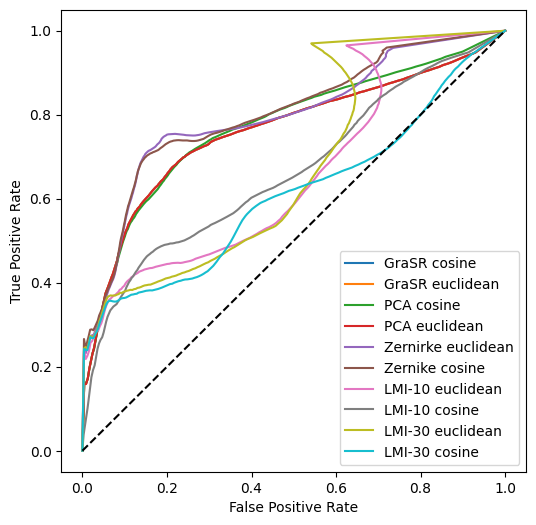

In [3]:
from matplotlib import pyplot as plt
import numpy as np

def binary_classification(ground_truth_file, evaluate_file, index):
    """
    Compute binary classification metrics for two json files.

    Args:
        ground_truth_file (str): path to first json file
        evaluate_file (str): path to second json file
        offset (float): skips samples in range (median-offset, median+offset)
        threshold (float): threshold for binary classification, if not set, median is used

    Returns:
        dict: dictionary with precision recall (tpr, fpr)
    """
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)

    x_threshold = list(json_x.values())[index]
    y_threshold = list(json_y.values())[index]

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for key in json_x:
        if json_x[key] < x_threshold and json_y[key] < y_threshold:
            true_positive += 1
        elif json_x[key] >= x_threshold and json_y[key] < y_threshold:
            false_positive += 1
        elif json_x[key] < x_threshold and json_y[key] >= y_threshold:
            false_negative += 1
        else:
            true_negative += 1

    if true_positive == 0 and (false_positive == 0 or false_negative == 0):
        return {
            "tpr": 0,
            "fpr": 0,
        }
    return {
            "tpr": true_positive / (true_positive + false_negative),
            "fpr": false_positive / (false_positive + true_negative),
        }

precision_recall = {}
auc = {}
map = {}

for embedding in EMBEDDINGS:
    precision_recall[embedding] = []
    for i in range(0, 1900//10):
        precision_recall[embedding].append([])

for protein in PROTEINS:
    for embedding in EMBEDDINGS:
        for i in range(0, 1900, 10):
            precision_recall[embedding][i//10].append(
                binary_classification(
                    f"results/{protein}-distances.json",
                    f"results/{protein}-distances-{embedding}.json",
                    index=i,
                )
            )

for embedding in EMBEDDINGS:
    average_fpr = [[v["fpr"] for v in l] for l in precision_recall[embedding]]
    average_tpr = [[v["tpr"] for v in l] for l in precision_recall[embedding]]

    average_fpr = np.mean(average_fpr, axis=1)
    average_tpr = np.mean(average_tpr, axis=1)
    average_fpr = list(average_fpr) + [1]
    average_tpr = list(average_tpr) + [1]

    plt.plot(average_fpr, average_tpr)

    auc_score = 0
    for i in range(1, len(average_fpr)):
        auc_score += (average_fpr[i] - average_fpr[i-1]) * average_tpr[i]
    auc[embedding] = auc_score

print(pd.DataFrame(auc.items(), columns=["config", "AUC"]).sort_values(by="AUC", ascending=False))

plt.legend(EMBEDDINGS_LEGEND)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.gcf().set_size_inches(6, 6)
plt.show()


In [6]:
import numpy as np

def average_precision(ground_truth_file, evaluate_file, threshold, cutoff=False):
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)
    
    if cutoff:
        # remove proteins with tm-score 0.4-0.6
        json_x = {k: v for k, v in json_x.items() if v < 0.4 or v > 0.6}
        json_y = {k: v for k, v in json_y.items() if k in json_x}
    x_true = [k for k, v in json_x.items() if v < threshold]
    y_true = [1 if k in x_true else 0 for k, v in json_y.items()]

    precision = []
    recall = []
    for i in range(1, len(x_true)):
        precision.append(sum(y_true[:i]) / i)
        recall.append(sum(y_true[:i]) / sum(y_true))
    
    return sum([precision[i] * (recall[i] - recall[i-1]) for i in range(1, len(precision))])

mean_ap_04 = {}
mean_ap_05 = {}
for embedding in EMBEDDINGS:
    mean_ap_05[embedding] = []
    mean_ap_04[embedding] = []

for embedding in EMBEDDINGS:
    for protein in PROTEINS:
        mean_ap_04[embedding].append(
            average_precision(
                f"results/{protein}-distances.json",
                f"results/{protein}-distances-{embedding}.json",
                0.4,
                cutoff=True,
            )
        )
        mean_ap_05[embedding].append(
            average_precision(
                f"results/{protein}-distances.json",
                f"results/{protein}-distances-{embedding}.json",
                0.5,
            )
        )
mean_ap_04_df = {(k, np.mean(v), np.std(v)) for k, v in mean_ap_04.items()}
mean_ap_05_df = {(k, np.mean(v), np.std(v)) for k, v in mean_ap_05.items()}
print("Mean average precision for threshold 0.4 with cutoff")
print(pd.DataFrame(mean_ap_04_df, columns=["config", "mAP", "std"]).sort_values(by="mAP", ascending=False))

print("\nMean average precision for threshold 0.5")
print(pd.DataFrame(mean_ap_05_df, columns=["config", "mAP", "std"]).sort_values(by="mAP", ascending=False))


Mean average precision for threshold 0.4 with cutoff
             config       mAP       std
3   zirke-euclidean  0.725975  0.196204
1      zirke-cosine  0.713369  0.185816
6   grasr-euclidean  0.662558  0.156790
7      grasr-cosine  0.662558  0.156790
8     pca-euclidean  0.662558  0.156790
2        pca-cosine  0.661424  0.159218
0     lmi-30-cosine  0.426852  0.176517
9        lmi-cosine  0.406976  0.139986
4     lmi-euclidean  0.402567  0.152253
5  lmi-30-euclidean  0.376704  0.136587

Mean average precision for threshold 0.5
             config       mAP       std
2   zirke-euclidean  0.694153  0.183263
7      zirke-cosine  0.679059  0.171003
8   grasr-euclidean  0.624132  0.150459
1      grasr-cosine  0.624132  0.150459
3     pca-euclidean  0.624132  0.150459
0        pca-cosine  0.623550  0.152417
6     lmi-30-cosine  0.415401  0.166178
9        lmi-cosine  0.392752  0.131278
4     lmi-euclidean  0.384031  0.147763
5  lmi-30-euclidean  0.362854  0.132271


In [ ]:
protein_tierlist = zip(mean_ap_04["zirke-euclidean"], PROTEINS)
protein_tierlist = sorted(protein_tierlist, reverse=True)

# print with ranks
print("Best performers according to 3d-af-surfer\n")
for i, (ap, protein) in enumerate(protein_tierlist):
    print(f"{i+1}. {protein} {ap:.3f}")

Best performers according to 3d-af-surfer

1. AF-D7PBG5-F1 0.884
2. AF-A0A1C9EMC3-F1 0.882
3. AF-A0A159H638-F1 0.879
4. AF-A0A343XVU5-F1 0.876
5. AF-A0A386LLN3-F1 0.876
6. AF-A0A344VJA7-F1 0.876
7. AF-A0A482HPU1-F1 0.875
8. AF-A0A386III0-F1 0.875
9. AF-A0A2U8YU98-F1 0.874
10. AF-A0A385YFZ6-F1 0.873
11. AF-A0A2Z5F384-F1 0.871
12. AF-A0A2I6Q5N0-F1 0.870
13. AF-A0A343XV74-F1 0.866
14. AF-A0A1U9GUA8-F1 0.861
15. AF-A0A2S1ZX05-F1 0.860
16. AF-A0A2Z4ERT0-F1 0.859
17. AF-A0A0A0MDK1-F1 0.859
18. AF-A0A141L453-F1 0.858
19. AF-A0A159E4H8-F1 0.857
20. AF-A0A346KW05-F1 0.856
21. AF-A0A220H7Z7-F1 0.852
22. AF-A0A3G1V387-F1 0.852
23. AF-A0A291QNQ6-F1 0.850
24. AF-A0A220ECL4-F1 0.835
25. AF-A0A6C0R830-F1 0.835
26. AF-A0A2Z5CT11-F1 0.834
27. AF-A0A3B8DT12-F1 0.826
28. AF-A0A6M8P3J6-F1 0.824
29. AF-A0A6G7HAL4-F1 0.824
30. AF-A0A2U9QQQ4-F1 0.822
31. AF-A0A3G1XEI5-F1 0.822
32. AF-A0A0M3LTA8-F1 0.821
33. AF-A0A0A0QIR8-F1 0.819
34. AF-H6B5E7-F1 0.816
35. AF-H6YZH9-F1 0.815
36. AF-B8XWA5-F1 0.812
37. AF-A0A

Range 0.6-1: 1006
Range 0.38-0.6: 485
Range 0.22-0.38: 374
Range 0-0.22: 135
Distribution of distances for Cow's Alpha albumin AF-P00711-F1


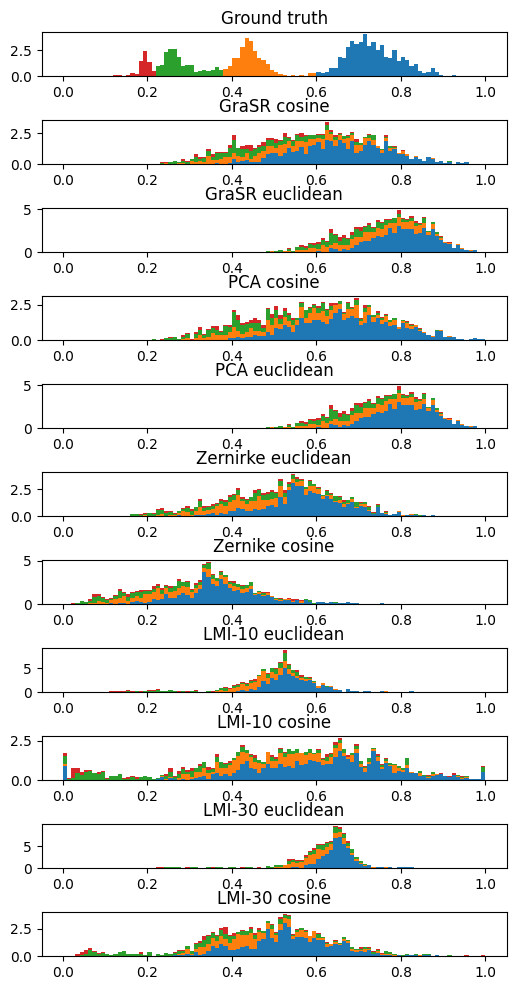

In [ ]:
from matplotlib import pyplot as plt

jsons = []
protein = "AF-P00711-F1"
with open(f"results/{protein}-distances.json", "r") as f:
    jsons.append(json.load(f))

ranges = [(0.6, 1), (0.38, 0.6), (0.22, 0.38), (0, 0.22)]
protein_filters = [[], [], [], []]
for i, (start, end) in enumerate(ranges):
    protein_filters[i] = [k for k, v in jsons[0].items() if start <= v < end]
    print(f"Range {start}-{end}:", len(protein_filters[i]))

for embedding in EMBEDDINGS:
    with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
        jsons.append(json.load(f))

for index, file in enumerate(jsons):
    plt.subplot(11, 1, index+1)
    plt.subplots_adjust(hspace=1)

    filtered_proteins = []
    for filt in protein_filters:
        filtered_proteins.append([v for k, v in file.items() if k in filt])
    plt.hist(filtered_proteins, density=True, histtype='bar', stacked=True, bins=100, range=(0,1), alpha=1)
    if index == 0:
        plt.title("Ground truth")
    else:
        plt.title(EMBEDDINGS_LEGEND[index-1])

plt.gcf().set_size_inches(6, 12)
print("Distribution of distances for Cow's Alpha albumin", protein)
plt.show()

Range 0.6-1: 955
Range 0.38-0.6: 215
Range 0.22-0.38: 126
Range 0-0.22: 700
Distribution of distances for Cow's Alpha albumin AF-D7PBG5-F1


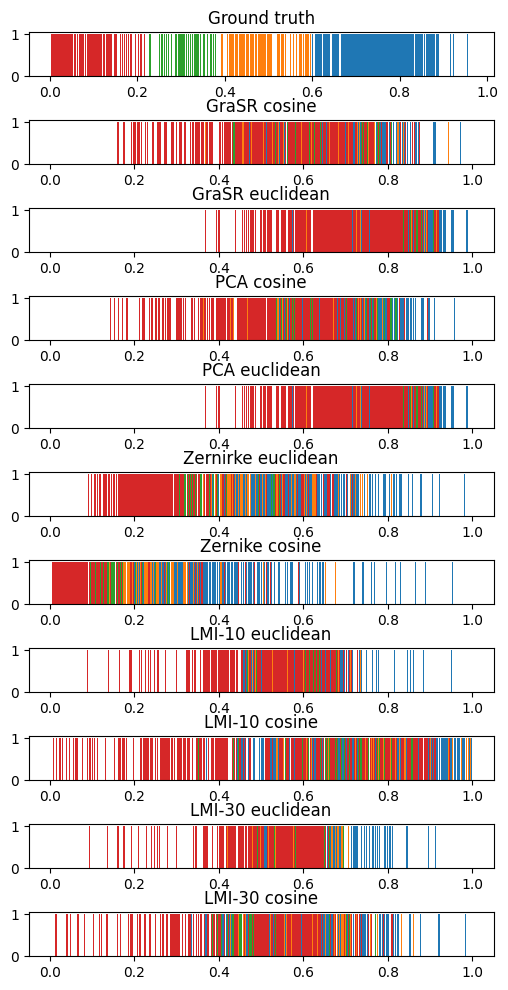

In [ ]:
from matplotlib import pyplot as plt
import json

jsons = []
protein = "AF-P00711-F1"
with open(f"results/{protein}-distances.json", "r") as f:
    jsons.append(json.load(f))

ranges = [(0.6, 1), (0.38, 0.6), (0.22, 0.38), (0, 0.22)]
protein_filters = [[], [], [], []]
for i, (start, end) in enumerate(ranges):
    protein_filters[i] = [k for k, v in jsons[0].items() if start <= v < end]
    print(f"Range {start}-{end}:", len(protein_filters[i]))

for embedding in EMBEDDINGS:
    with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
        jsons.append(json.load(f))

for index, file in enumerate(jsons):
    plt.subplot(11, 1, index+1)
    plt.subplots_adjust(hspace=1)

    filtered_proteins = []
    for filt in protein_filters:
        filtered_proteins = [v for k, v in file.items() if k in filt]
        plt.bar(filtered_proteins, [1] * len(filtered_proteins), width=0.001, alpha=1)
    if index == 0:
        plt.title("Ground truth")
    else:
        plt.title(EMBEDDINGS_LEGEND[index-1])


plt.gcf().set_size_inches(6, 12)
print("Distribution of distances for Cow's Alpha albumin", protein)
plt.show()

Distribution of distances for AF-A0A2U9QQQ4-F1


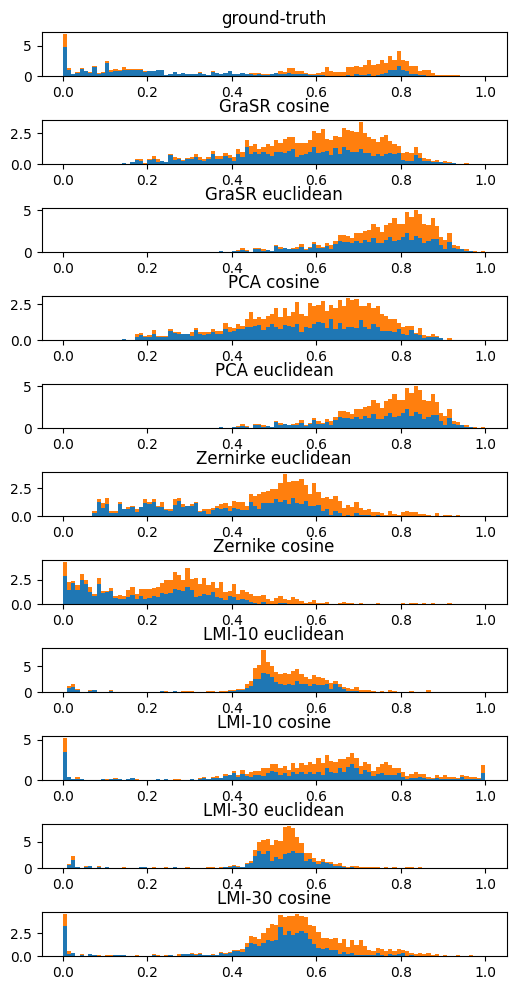

In [ ]:
from matplotlib import pyplot as plt

# visualize distribution of selected protein
# best performing: AF-D7PBG5-F1, AF-A0A1C9EMC3-F1, AF-A0A159H638-F1
# mids: AF-H6B5E7-F1 (rat), A0A2U9QQQ4 (snail)
# worst performing: AF-A0A109MZW9-F1, AF-A0A1X9I7D1-F1, AF-A0A386IHZ5-F1

jsons = []
protein_index = next((i for i, v in enumerate(PROTEINS) if v == "AF-A0A2U9QQQ4-F1"))
with open(f"results/{PROTEINS[protein_index]}-distances.json", "r") as f:
    jsons.append(json.load(f))

with open(f"foldseek-files/A0A2U9QQQ4", "r") as f:
    f = f.read().split()
    foldseek_proteins = [w for w in f if w.startswith("AF-")]
    foldseek_proteins = [w.split("-model")[0].split("-")[1] for w in foldseek_proteins]

#ranges = [(0.5, 1), (0, 0.5)]
protein_filters = [foldseek_proteins, [k for k in jsons[0].keys() if k not in foldseek_proteins]]
#for i, (start, end) in enumerate(ranges):
#    protein_filters[i] = [k for k, v in jsons[0].items() if start <= v <= end]
#    print(f"Range {start}-{end}:", len(protein_filters[i]))

for embedding in EMBEDDINGS:
    with open(f"results/{PROTEINS[protein_index]}-distances-{embedding}.json", "r") as f:
        jsons.append(json.load(f))

for index, file in enumerate(jsons):
    plt.subplot(11, 1, index+1)
    plt.subplots_adjust(hspace=1)

    filtered_proteins = []
    for filt in protein_filters:
        filtered_proteins.append([v for k, v in file.items() if k in filt])
    plt.hist(filtered_proteins, density=True, histtype='bar', stacked=True, bins=100, range=(0,1), alpha=1)
    if index == 0:
        plt.title("ground-truth")
    else:
        plt.title(EMBEDDINGS_LEGEND[index-1])

plt.gcf().set_size_inches(6, 12)
print("Distribution of distances for", PROTEINS[protein_index])
plt.show()

Range 0.5-1: 1125
Range 0.25-0.5: 236
Range 0-0.25: 640
Distribution of distances for AF-A0A2U9QQQ4-F1


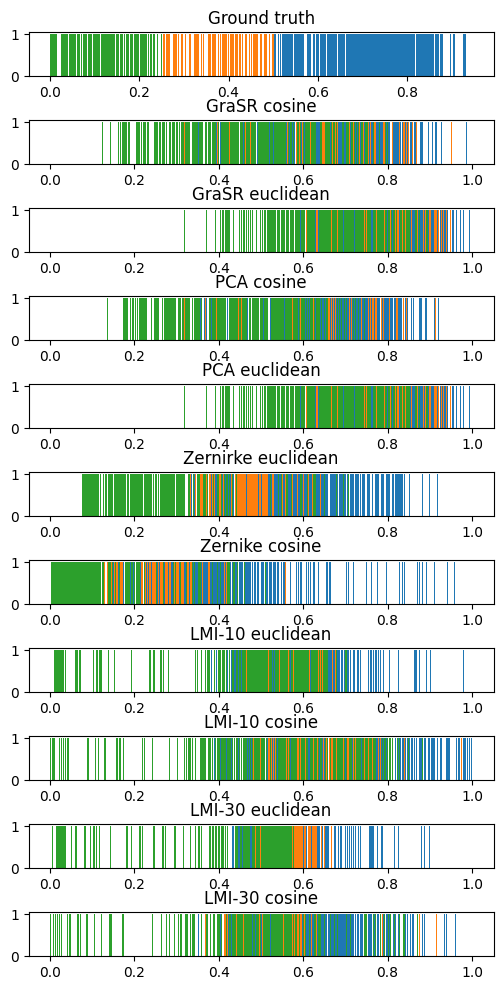

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import json

jsons = []
protein = "AF-A0A2U9QQQ4-F1"
with open(f"results/{protein}-distances.json", "r") as f:
    jsons.append(json.load(f))

ranges = [(0.5, 1), (0.25, 0.5), (0, 0.25)]
protein_filters = [[], [], []]
for i, (start, end) in enumerate(ranges):
    protein_filters[i] = [k for k, v in jsons[0].items() if start <= v < end]
    print(f"Range {start}-{end}:", len(protein_filters[i]))

for embedding in EMBEDDINGS:
    with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
        jsons.append(json.load(f))

for index, file in enumerate(jsons):
    plt.subplot(11, 1, index+1)
    plt.subplots_adjust(hspace=1)

    filtered_proteins = []
    for filt in protein_filters:
        filtered_proteins = [v for k, v in file.items() if k in filt]
        plt.bar(filtered_proteins, [1] * len(filtered_proteins), width=0.001, align="edge")
    if index == 0:
        plt.title("Ground truth")
    else:
        plt.title(EMBEDDINGS_LEGEND[index-1])


plt.gcf().set_size_inches(6, 12)
print("Distribution of distances for", protein)
plt.show()

TM-distance density


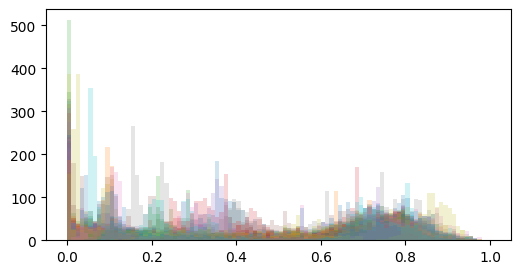

In [7]:
jsons = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json", "r") as f:
        jsons.append(json.load(f))
for file in jsons:
    plt.hist(file.values(), bins=100, range=(0,1), alpha=0.2)

plt.gcf().set_size_inches(6, 3)

print("TM-distance density")
plt.show()

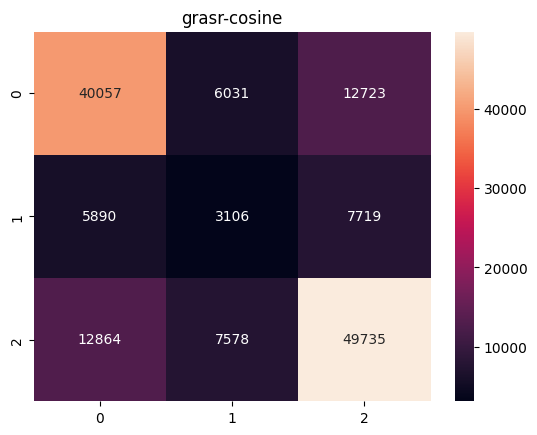

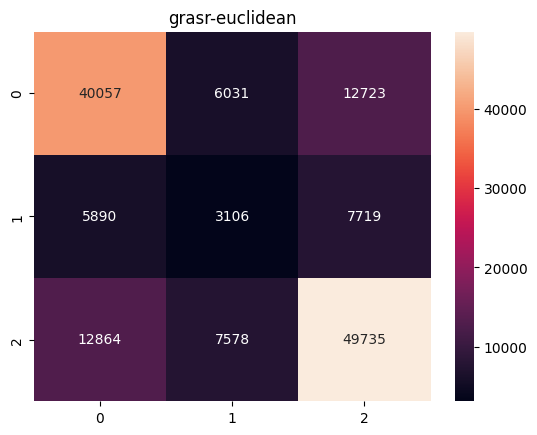

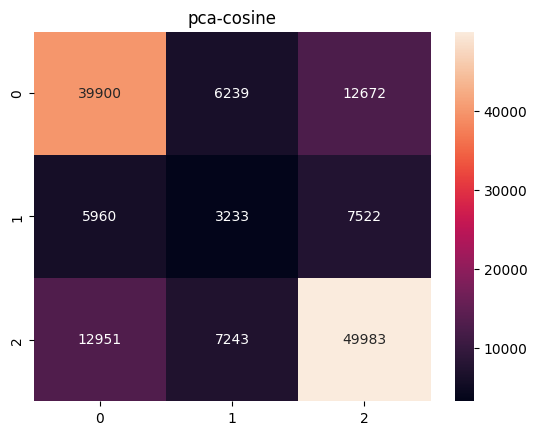

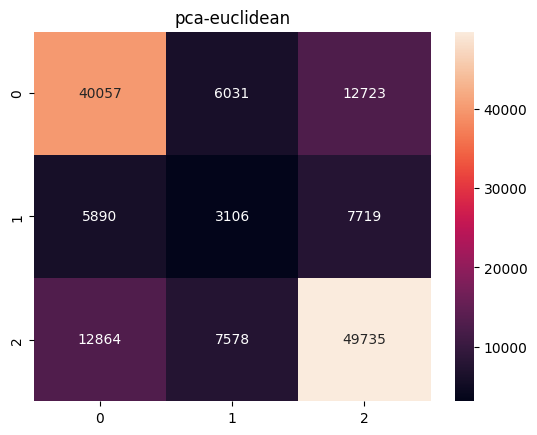

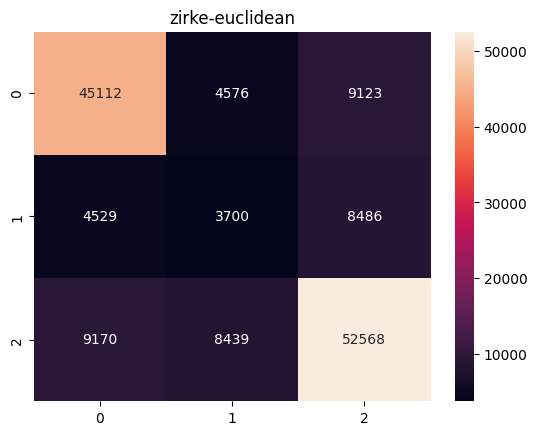

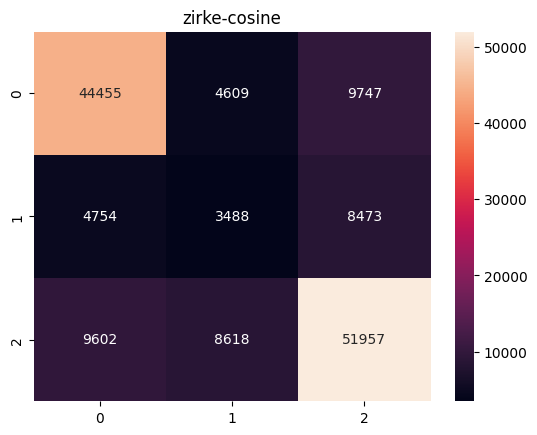

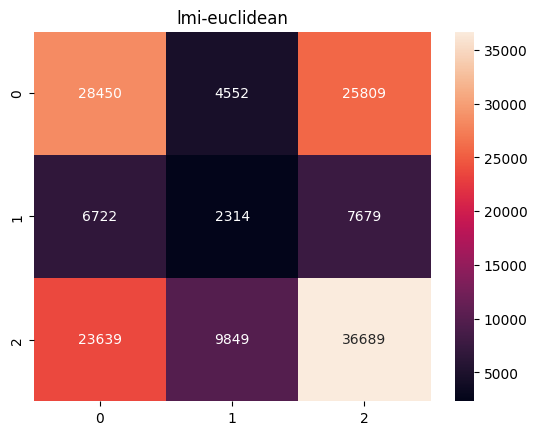

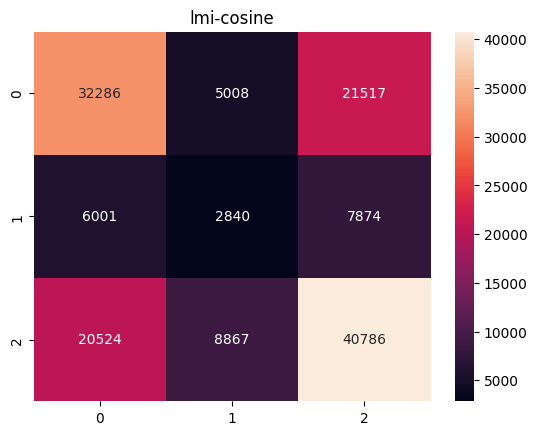

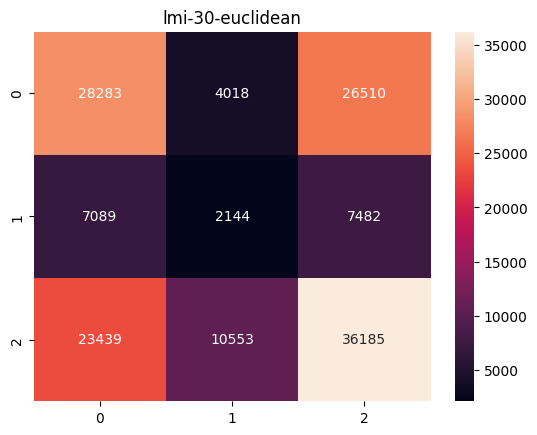

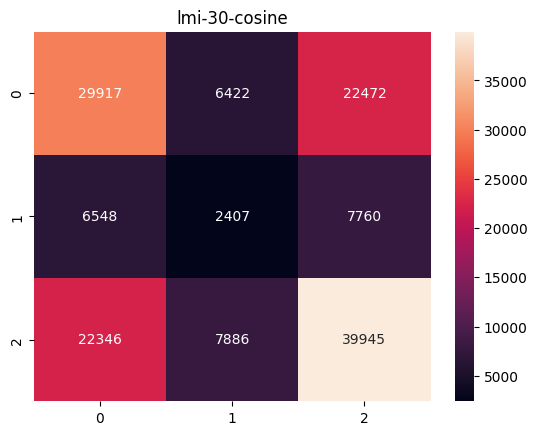

In [ ]:
# confusion matrix for 3 classes

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy


protein = "AF-A0A2U9QQQ4-F1"
y_trues = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json", "r") as f:
        y_true = json.load(f)


    ranges = [(0, 0.4), (0.4, 0.6), (0.6, 1)]
    for i, (start, end) in enumerate(ranges):
        for key, value in y_true.items():
            if start <= value < end:
                y_true[key] = i
    
    y_trues.append(copy(y_true))

# flatten y_trues.values
y_trues_flat = [list(y_true.values()) for y_true in y_trues]
y_trues_flat = [item for sublist in y_trues_flat for item in sublist]

for embedding in EMBEDDINGS:
    jsons = []
    for protein in PROTEINS:
        with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
            jsons.append(json.load(f))

    y_pred = []
    for index, file in enumerate(jsons):
        for key in file.keys():
            y_pred.append(y_trues[index][key])

    matrix = confusion_matrix(y_trues_flat, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d")
    plt.title(embedding)
    plt.show()

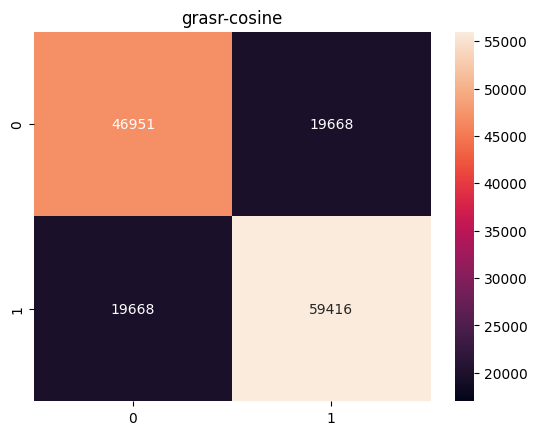

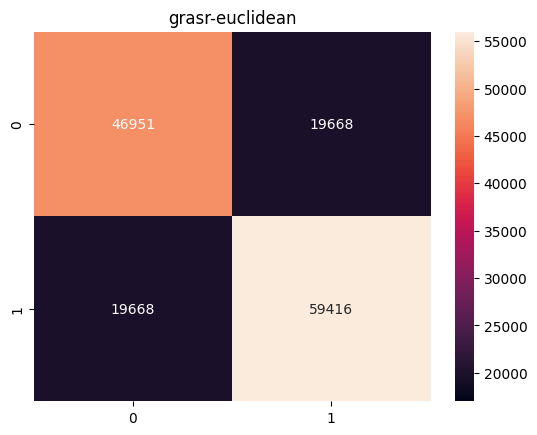

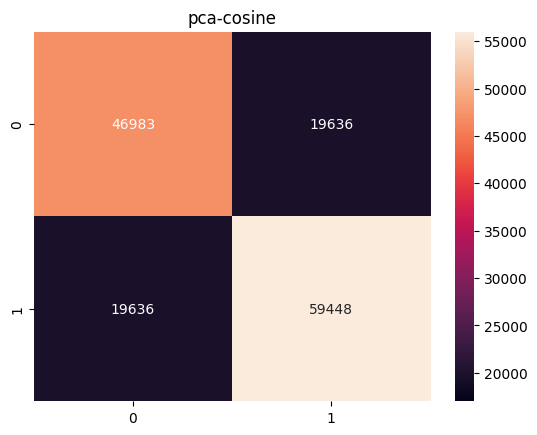

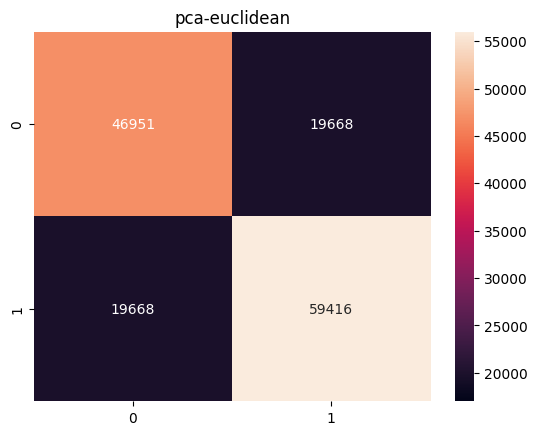

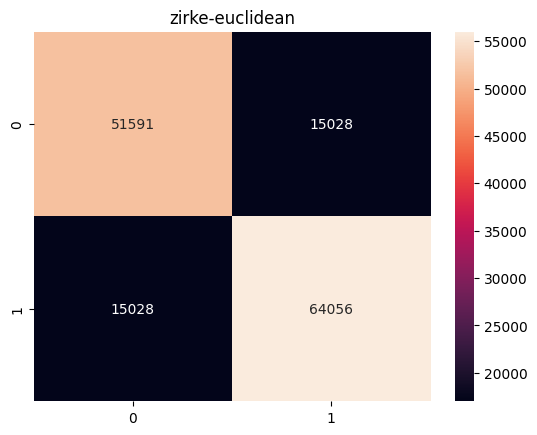

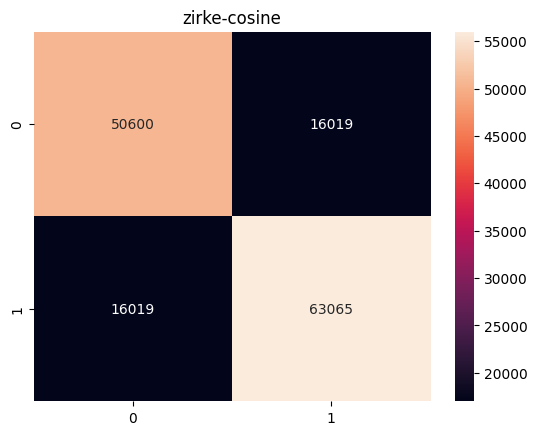

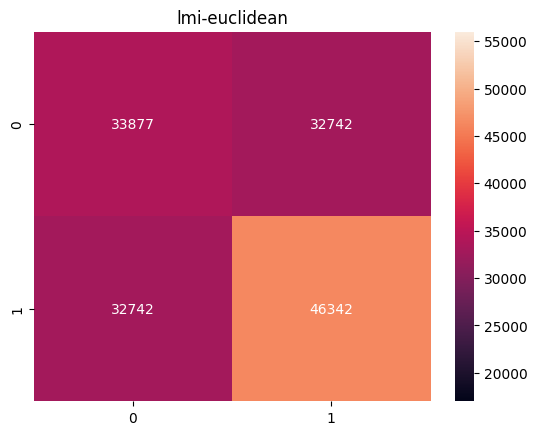

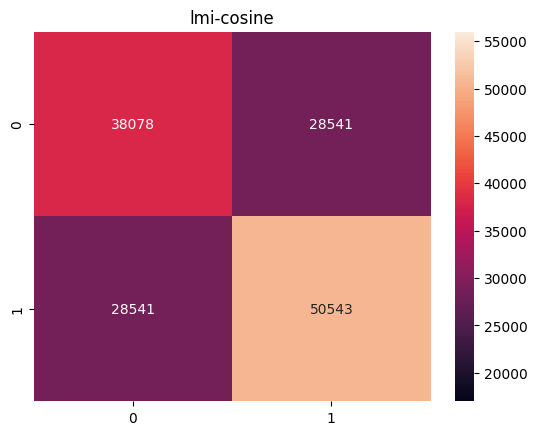

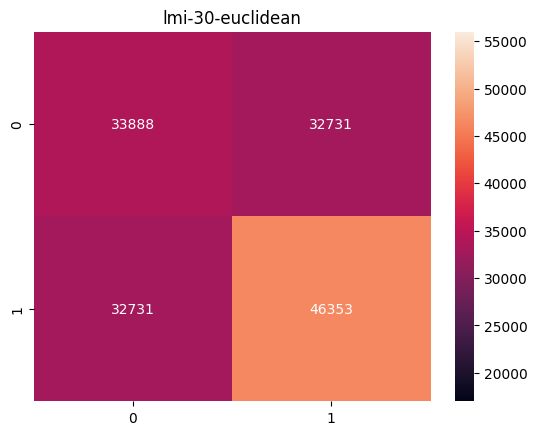

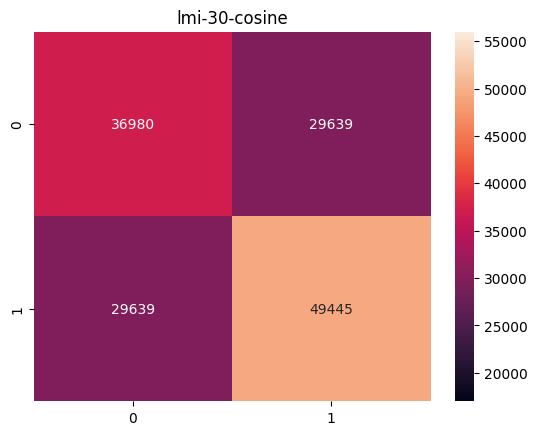

In [ ]:
# confusion matrix for median

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
import numpy as np


protein = "AF-A0A2U9QQQ4-F1"
y_trues = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json", "r") as f:
        y_true = json.load(f)

    #median = np.median(list(y_true.values()))
    median = 0.5
    ranges = [(0, median), (median, 1)]
    for i, (start, end) in enumerate(ranges):
        for key, value in y_true.items():
            if start <= value < end:
                y_true[key] = i
    
    y_trues.append(copy(y_true))

# flatten y_trues.values
y_trues_flat = [list(y_true.values()) for y_true in y_trues]
y_trues_flat = [item for sublist in y_trues_flat for item in sublist]

for embedding in EMBEDDINGS:
    jsons = []
    for protein in PROTEINS:
        with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
            jsons.append(json.load(f))

    y_pred = []
    for index, file in enumerate(jsons):
        for key in file.keys():
            y_pred.append(y_trues[index][key])

    matrix = confusion_matrix(y_trues_flat, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d", vmin=17000, vmax=56000)
    plt.title(embedding)
    plt.show()